# Imports (clean up!)

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import glob
import random
import cv2
from random import shuffle
import csv

# Data

## Dataset (PyTorch)
von 
https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

bzw. 
https://colab.research.google.com/drive/1y6M-L7f-L54ewIG-buo3Su28ocPwXhbf#scrollTo=TW4hyfiP_CLl

In [31]:
import torch
from torch.utils.data import Dataset
#from torchvision import datasets
#from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [32]:
import os
import pandas as pd
#from torchvision.io import read_image

In [33]:
# used for transform! (both landscape and metric)
# class for changing images totensor. really necessary? ...
# according to https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
class ToTensor(object):
    """Convert ndarrays of Dataset to Tensors.
      for now only for the landscapes, can add for labels later on"""
    def __call__(self, landscape, metric):
        #landscape, metric = sample['landscape'], sample['metric']
        landscape = landscape[None, :] # add channel dimension 
        metric = metric[None, :]
        return torch.from_numpy(landscape), torch.from_numpy(metric)
        #return torch.Tensor(landscape), torch.Tensor(metric)   

In [58]:
# Class level dataset: Landscapes as arrays, metrics as single values or arrays!!

class LandscapeMetricsDataset(Dataset):
    """Dataset for landscapes and their metrics data"""

    def __init__(self, landscape_dir, ls_list, metrics_dir=None, transform=None, target_transform=None):
        """Initialising dataset, including locations of landscapes and metrics
        if class or patch lvl: enter metrics_dir; 
        if landscape_lvl: enter metrics_file.csv;
        in metrics_file the second column either has landscape lvl metrics or
        file names of patch/class lvl metrics
        could leave out metric_lvl, just do "if metrics_dir: do this ...seems good
        """
        
        self.ls_list = pd.read_csv(ls_list) #no panda?
        #self.metrics_file = csv.reader(ls_list)
        #self.metrics_file = np.genfromtxt(ls_list, delimiter = ',')

        self.metrics_dir = metrics_dir
        self.landscape_dir = landscape_dir        
        self.transform = transform
        self.target_transform = target_transform


    def __len__(self):
        """get length of dataset"""

        return len(self.metrics_file)

    def __getitem__(self, idx):
        """retrieve one item from dataset"""

        landscape_path = os.path.join(self.landscape_dir, self.ls_list.iloc[idx, 0])
        #landscape = read_image(landscape_path) # instead of read image directly read as arrray and transform to tensor
        #landscape = np.genfromtxt(landscape_path) # import landscapes from csv to array # to np.load
        landscape = np.load(landscape_path) # import landscapes from csv to array # to np.load
        #landscape = landscape.astype('int8') # int as numbers are integers. int 8 as there are only 3 classes for now (can be changed later)
        landscape = landscape.astype('float32')
        # source: https://www.reddit.com/r/MachineLearning/comments/9m9q70/d_choosing_datatype_for_vector_embedding_integers/
        # https://engineering.fb.com/2018/09/07/ai-research/scaling-neural-machine-translation-to-bigger-data-sets-with-faster-training-and-inference/
        #landscape = torch.Tensor(landscape) # array to tensor (optinally elswhere/using transform?); moved to class ToTensor
        # landscape = landscape[None, :] # add channel dimension; moved to class ToTensor
        #if self.metric_lvl == "landscape_lvl":
        #    metric = self.metrics_file.iloc[idx, 1]
        #elif self.metric_lvl == "patch_lvl" or self.metric_lvl == "class_lvl":
        metric_path = os.path.join(self.metrics_dir, self.ls_list.iloc[idx, 1])
        #etric = np.genfromtxt(metric_path)
        metric = np.load(metric_path)
        #metric = metric.astype('float32') # which data type here? try float 16 later
            # 16? : https://www.georgeho.org/floating-point-deep-learning/
        # alternatively (without using metric_lvl):
        # if self.metrics_dir:
            #metric_path = os.path.join(self.metrics_dir, self.metrics_file.iloc[idx, 1])
            #metric = np.genfromtxt(metric_path)
        metric = metric.astype('float32')
        # else:
        #   metric = self.metrics_file.iloc[idx, 1]
        if self.transform:
            landscape, metric = self.transform(landscape, metric)
        return landscape, metric

## Initialize Dataset
with landscapes and metrics given their respective locations

In [59]:
#metric_lvl = "class_lvl"
landscape_dir = "data/landscapes_npy"
ls_list = "data/metric_list_npy.csv"
metrics_dir = "data/metrics_npy"
landscapes_dataset = LandscapeMetricsDataset(ls_list=ls_list, metrics_dir=metrics_dir, landscape_dir=landscape_dir, transform=ToTensor())

In [60]:
landscapes_dataset.__getitem__(1)#[0][0][0] # testing getitem
#type(landscapes_dataset.__getitem__(2)[0]) #[0][0][0]) # testing getitem)

(tensor([[[2., 2., 1.,  ..., 2., 2., 2.],
          [2., 2., 1.,  ..., 2., 2., 2.],
          [2., 2., 2.,  ..., 1., 2., 2.],
          ...,
          [2., 1., 3.,  ..., 2., 2., 2.],
          [2., 1., 1.,  ..., 2., 2., 2.],
          [2., 1., 1.,  ..., 2., 2., 2.]]]),
 tensor([[[0.3457, 0.4861, 0.4978,  ..., 0.4800, 0.4028, 0.1975],
          [0.2778, 0.4688, 0.5000,  ..., 0.3950, 0.3203, 0.1528],
          [0.2311, 0.4550, 0.4992,  ..., 0.3328, 0.2650, 0.1244],
          ...,
          [0.6667, 0.6550, 0.6656,  ..., 0.0000, 0.0000, 0.0000],
          [0.6528, 0.6484, 0.6650,  ..., 0.0000, 0.0000, 0.0000],
          [0.5679, 0.5694, 0.6044,  ..., 0.0000, 0.0000, 0.0000]]]))

## Initialize DataLoader

In [12]:
len(landscapes_dataset)

3999

In [13]:
# hyperparameters

batch_size = 64

In [14]:
# https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split
# split dataset into training and testing. 
# rando generator seed for reproducabitly included!
from torch.utils.data import DataLoader, random_split

# split dataset
train_data, validation_data, test_data = random_split(dataset=landscapes_dataset, lengths=[2999,500,500], generator=torch.Generator().manual_seed(42))

# attach dataloader
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

## Display image and label (for class/patch level)

Feature batch shape: torch.Size([64, 1, 128, 128])
Labels batch shape: torch.Size([64, 1, 128, 128])


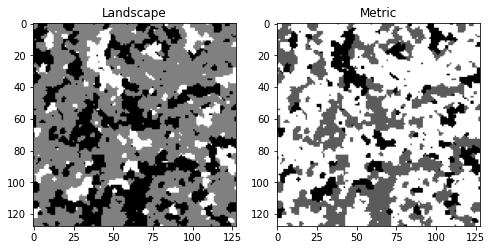

In [15]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0].squeeze()
columns = 2
rows = 1
fig = plt.figure(figsize=(8,8))
fig.add_subplot(rows, columns, 1)
plt.title("Landscape")
#plt.legend(labels = "Gray")
plt.imshow(img, cmap = "gray")
fig.add_subplot(rows, columns, 2)
plt.title("Metric")
#plt.legend(labels = "Gray")
plt.imshow(label, cmap = "gray")
plt.show()
#print(f"Label: {label}")

In [16]:
torch.unique(train_labels[0].squeeze())

tensor([0.2028, 0.4748, 0.9608])

# UNet (pytorch)
based on: 
https://amaarora.github.io/2020/09/13/unet.html

## Block Class
2 Convolutions with ReLU
use nn.Conv2d or impor from torch.nn?
used by both Encoder and Decoder!

In [17]:
from torch.nn import Conv2d, ReLU, Module, ModuleList, MaxPool2d, ConvTranspose2d

In [18]:
class Block(Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = Conv2d(in_ch, out_ch, 3)
        self.relu = ReLU()
        self.conv2 = Conv2d(out_ch, out_ch, 3)

    def forward(self, x):
        return self.relu(self.conv2(self.relu(self.conv1(x))))

In [19]:
enc_block = Block(1,64)
x = torch.randn(1,1,128,128)
enc_block(x).shape

torch.Size([1, 64, 124, 124])

## Encoder class
built out of EncodeBlocks and max pools
runs the whole encoding side of unet after being called just once and returns all intemediary pooling results

In [20]:
class Encoder(Module):
    def __init__(self, chs=(1,64,128,256,512)): #,1024)): # why this, why this?
        super().__init__()
        self.enc_blocks = ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) # creates all Blocks needed for the Encoder and stores them in a ModuleList
        self.pool = MaxPool2d(2) # maxpool with kernel size 2x2

    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs

In [21]:
#testing encoder:
encoder = Encoder()
#x = torch.randn(1,1,572,572)
x = torch.randn(1,1,128,128)
#x = torch.randn(1,1,256,256)
ftrs = encoder(x)
for ftr in ftrs:
    print(ftr.shape)

torch.Size([1, 64, 124, 124])
torch.Size([1, 128, 58, 58])
torch.Size([1, 256, 25, 25])
torch.Size([1, 512, 8, 8])


## Decoder class
analagously to encoder?

In [22]:
from torchvision.transforms import CenterCrop

In [23]:
class Decoder(Module):
    def __init__(self, chs=(512, 256, 128, 64)): #chs=(1024, 512, 256, 128, 64)): # no one, why? i guess it's not needed anymore, or it happens afterwards, eg by a fully connected layer or something? (which we dont have, supposedly)
        super().__init__()
        self.chs = chs # need separately for using it in forward.
        self.upconvs = ModuleList([ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)]) # these list comprehensions are a bit messy, but i guess if it works...
        self.dec_blocks = ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
 
    
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x = torch.cat([x, enc_ftrs], dim=1) # dim = 1 why? because of *thing* ?
            x = self.dec_blocks[i](x)
        return x

    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs = CenterCrop([H, W])(enc_ftrs) # the skip-connection-features are cropped to the extent of the up-convoluted layers
        return enc_ftrs

In [24]:
# testing decoder:
decoder = Decoder()
#x = torch.randn(1,1024,28,28)
x = torch.randn(1,512,8,8)
decoder(x,ftrs[::-1][1:]).shape # reverse features to concateante them backwards; last feateree is not concatenated but directly upsampled!

torch.Size([1, 64, 36, 36])

## U-Net
combining encoder and decoder

In [25]:
from  torch.nn.functional import interpolate

In [26]:
class unet(Module):   # dimensions = (1,128,128) 
    #def __init__(self, enc_chs=(1,64,128,256,512,1024), dec_chs=(1024,512,256,128,64), num_class=1, retain_dim=False, out_sz=(572,572)):
    def __init__(self, enc_chs=(1,64,128,256,512), dec_chs=(512,256,128,64), num_class=1, retain_dim=False, out_sz=(128,128)):
        super().__init__()
        self.encoder = Encoder(enc_chs)
        self.decoder = Decoder(dec_chs)
        self.head = Conv2d(dec_chs[-1], num_class, 1) # head to create the final output based on the features created by the model (the decoder in this case, top right in U-Net)
        self.retain_dim = retain_dim
        self.out_sz = out_sz

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out = self.decoder(enc_ftrs[::-1][0],enc_ftrs[::-1][1:]) # no way, i actualyl did this myself! I actualy understood something! wow!
        out = self.head(out) # forgot to add the head there
        if self.retain_dim:
            out = interpolate(out, self.out_sz) # was wrong (i think), adjusted it
        return out

In [27]:
unet = unet(retain_dim=True)
x = torch.randn(1,1,128,128)
unet(x).shape

torch.Size([1, 1, 128, 128])

# U-Net Encoder only
for classification

In [ ]:
from  torch.nn.functional import interpolate

In [ ]:
class unet(Module):   # dimensions = (1,128,128) 
    #def __init__(self, enc_chs=(1,64,128,256,512,1024), dec_chs=(1024,512,256,128,64), num_class=1, retain_dim=False, out_sz=(572,572)):
    #def __init__(self, enc_chs=(1,64,128,256,512), dec_chs=(512,256,128,64), num_class=1, retain_dim=False, out_sz=(128,128)):
    def __init__(self, enc_chs=(1,64,128,256,512), num_class = 1):
        super().__init__()
        self.encoder = Encoder(enc_chs)
        #self.decoder = Decoder(dec_chs)
        #self.head = Conv2d(dec_chs[-1], num_class, 1) # head to create the final output based on the features created by the model (the decoder in this case, top right in U-Net)
        self.head = Conv2d(enc_chs[-1], num_class, 1) # head to create the final output based on the features created by the model (the decoder in this case, top right in U-Net)
        #self.retain_dim = retain_dim
        #self.out_sz = out_sz

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        #out = self.decoder(enc_ftrs[::-1][0],enc_ftrs[::-1][1:]) # no way, i actualyl did this myself! I actualy understood something! wow!
        out = self.head(enc_ftrs[::-1][0],enc_ftrs[::-1][1:]) # forgot to add the head there
        #if self.retain_dim:
        #    out = interpolate(out, self.out_sz) # was wrong (i think), adjusted it
        return out

NameError: ignored

In [ ]:
unet = unet(retain_dim=True)
x = torch.randn(1,1,128,128)
unet(x).shape

# Training (pytorch)
for now: copy code from 
https://pytorch.org/tutorials/beginner/introyt/trainingyt.html
for training one epoch

In [ ]:
from torch.optim import Adam # basic optimizer f or now
from torch.nn import CrossEntropyLoss # basic loss function for now
# hyperparameters
optimizer = Adam
loss_fn = CrossEntropyLoss()
model = unet

In [ ]:
dummy_outputs = torch.rand(4, 10)
# Represents the correct class among the 10 being tested
dummy_labels = torch.tensor([1, 5, 3, 7])

print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('Total loss for this batch: {}'.format(loss.item()))

tensor([[0.3835, 0.9566, 0.1852, 0.5396, 0.5838, 0.9474, 0.4899, 0.7012, 0.4359,
         0.6812],
        [0.9190, 0.7193, 0.3787, 0.3661, 0.6484, 0.5096, 0.6140, 0.7059, 0.6068,
         0.2701],
        [0.8551, 0.7290, 0.5174, 0.8391, 0.4038, 0.5878, 0.6150, 0.4935, 0.5322,
         0.4908],
        [0.4779, 0.3197, 0.3214, 0.2733, 0.1535, 0.9970, 0.8144, 0.6370, 0.4513,
         0.8099]])
tensor([1, 5, 3, 7])
Total loss for this batch: 2.1635639667510986


In [ ]:
def train_one_epoch(epoch_index):
    """taken from the web. basic training setup"""

    #running_loss = 0
    #last_lass = 0

    # get the inputs and labels for every step i
    for i, data in enumerate(train_dataloader):
        inputs, labels = data

        # do i have to zero them?
        "It is beneficial to zero out gradients when building a neural network. This is because by default, gradients are accumulated in buffers (i.e, not overwritten) whenever .backward() is called."
        optimizer.zero_grad()

        outputs = model(inputs)

        loss = loss_fn(outputs,labels)
        loss.backward()

        optimizer.step()
    print(loss)
    return loss

In [ ]:
train_one_epoch(1)

# training copy paste

In [ ]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_dataloader):
        # Every data instance is an input + label pair
        inputs, labels = data
        #inputs, labels = inputs.squeeze(1), labels.squeeze(1)
        print(inputs.size())
        print(labels.size())

        # Zero your gradients for every batch!
        #optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)
        print(outputs.size())
        outputs = outputs.squeeze(1) # warum hier????
        print(outputs.size())


        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(train_dataloader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [ ]:
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter

# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(validation_dataloader):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

# Training (for unet, does this work?)
https://towardsdatascience.com/u-net-b229b32b4a71

In [ ]:
inputs, labels = next(iter(train_dataloader))

In [ ]:
#unet = unet #in_channel=1,out_channel=2)
#out_channel represents number of segments desired
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(unet.parameters(), lr = 0.01, momentum=0.99)
optimizer.zero_grad()       
outputs = unet(inputs)
# permute such that number of desired segments would be on 4th dimension
outputs = outputs.permute(0, 2, 3, 1)
m = outputs.shape[0]
print(outputs.shape)
print(outputs.shape[0], outputs.shape[1], outputs.shape[2], outputs.shape[3])
width_out, height_out = outputs.shape[1], outputs.shape[2]
print(m, width_out, height_out)
# Resizing the outputs and label to caculate pixel wise softmax loss
outputs = outputs.resize(m*width_out*height_out, 1)
labels = labels.resize(m*width_out*height_out)
#outputs = outputs.squeeze(1)
#print(outputs.shape[0], outputs.shape[1], outputs.shape[2])
print(outputs.shape)
print(labels.shape)
loss = criterion(outputs, labels)
loss.backward()
optimizer.step()

torch.Size([64, 128, 128, 1])
64 128 128 1
64 128 128
torch.Size([1048576, 1])
torch.Size([1048576])


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:549: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


RuntimeError: ignored

# Training (tensorflow)

In [ ]:
train_steps = len(train_data) //batch_size
validation_steps = len(validation_data) //batch_size
model.fit_generator(train_generator, 
                    epochs = 30, steps_per_epoch = train_steps,validation_data = test_generator, validation_steps = test_steps,
                    callbacks = build_callbacks(), verbose = 0)